In [194]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [195]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import clip
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
COCO_PATH = Path(r"C:\Users\barta\Documents\cours\iaprojets\PDR\code\datasets\coco\train2017\train2017")  
SHIFT_VALUES = list(range(0,4))  
NUM_IMAGES = 50

print(f"Device utilisé: {DEVICE}")

Device utilisé: cuda


Test: Original shape (480, 640, 3), Encrypted shape (480, 640, 3)


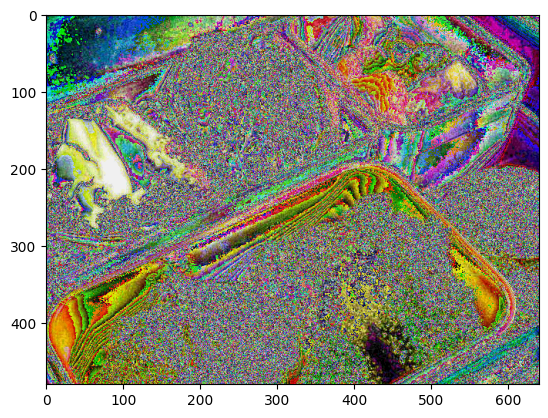

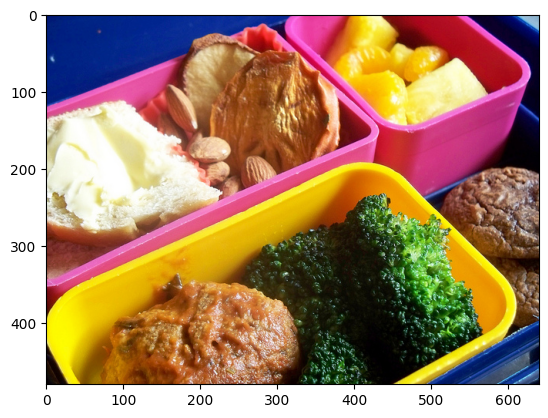

In [196]:
def encrypt_image_bitshift(image_array, shift):
    """
    Chiffre une image en décalant les bits.
    
    Args:
        image_array: np.array de forme (H, W, 3) avec valeurs 0-255
        shift: int entre 0 et 8
            - 0: aucun changement
            - 8: tous les bits à 0 (chiffrement total)
    
    Returns:
        Image chiffrée (np.array)
    """
    if shift == 0:
        return image_array.copy()
    elif shift == 8:
        return np.zeros_like(image_array)
    else:
        encrypted = image_array << shift
        return encrypted.astype(np.uint8)

# Test rapide
test_img = np.array(Image.open(list(COCO_PATH.glob("*.jpg"))[0]).convert('RGB'))
test_enc = encrypt_image_bitshift(np.array(test_img), 4)
print(f"Test: Original shape {test_img.shape}, Encrypted shape {test_enc.shape}")
plt.imshow(test_enc)
plt.show()
plt.imshow(test_img)
plt.show()

In [197]:
def compute_pixel_entropy(image_array):
    """
    Calcule l'entropie de Shannon des pixels d'une image.
    
    Args:
        image_array: np.array de forme (H, W, 3)
    
    Returns:
        float: entropie moyenne sur les 3 canaux
    """
    entropies = []
    
    for channel in range(3):
        # Histogramme du canal
        hist, _ = np.histogram(image_array[:, :, channel], bins=256, range=(0, 256))
        # Normalisation pour obtenir une distribution de probabilité
        prob_dist = hist / hist.sum()
        # Calcul de l'entropie (en bits)
        ent = entropy(prob_dist, base=2)
        entropies.append(ent)
    
    return np.mean(entropies)

# Test
test_entropy = compute_pixel_entropy(test_img)
print(f"Entropie test: {test_entropy:.4f} bits")

Entropie test: 7.6028 bits


In [198]:
def compute_mi_histogram(img1, img2, bins=256):
    """
    Calcule l'information mutuelle entre deux images par histogrammes.
    
    Args:
        img1, img2: np.array de forme (H, W, 3)
        bins: nombre de bins pour l'histogramme
    
    Returns:
        float: information mutuelle moyenne sur les 3 canaux
    """
    mi_values = []
    
    for channel in range(3):
        # Aplatir les canaux
        c1 = img1[:, :, channel].flatten()
        c2 = img2[:, :, channel].flatten()
        
        # Calculer l'IM avec sklearn
        mi = mutual_info_score(c1, c2)
        mi_values.append(mi)
    
    return np.mean(mi_values)

# Test
test_mi = compute_mi_histogram(test_img, test_enc)
print(f"MI histogramme test: {test_mi:.4f}")

MI histogramme test: 2.7586


In [199]:
# Charger CLIP
model, preprocess = clip.load("ViT-B/32", device=DEVICE)
model.eval()

print("Modèle CLIP chargé avec succès")
print(f"Preprocessing: {preprocess}")

Modèle CLIP chargé avec succès
Preprocessing: Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x000002705F16DE40>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


In [200]:
def get_clip_embedding(image_array):
    """
    Extrait l'embedding CLIP d'une image.
    
    Args:
        image_array: np.array de forme (H, W, 3) avec valeurs 0-255
    
    Returns:
        np.array: vecteur d'embedding de dimension 512
    """
    # Convertir en PIL Image
    pil_image = Image.fromarray(image_array)
    
    # Prétraitement CLIP
    image_input = preprocess(pil_image).unsqueeze(0).to(DEVICE)
    
    # Extraction de l'embedding
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        # Normalisation
        image_features /= image_features.norm(dim=-1, keepdim=True)
    
    return image_features.cpu().numpy().flatten()

# Test
test_embedding = get_clip_embedding(test_img)
print(f"Embedding shape: {test_embedding.shape}")

Embedding shape: (512,)


In [201]:
def process_single_image(image_path, shift_values):
    """
    Traite une image pour tous les shifts et calcule les métriques.
    
    Args:
        image_path: Path vers l'image
        shift_values: liste des valeurs de shift à tester
    
    Returns:
        dict contenant toutes les métriques
    """
    # Charger l'image
    img = Image.open(image_path).convert('RGB')
    img_array = np.array(img)
    
    # Embedding original
    emb_orig = get_clip_embedding(img_array)
    
    # Entropie originale
    entropy_orig = compute_pixel_entropy(img_array)
    
    results = []
    
    for shift in shift_values:
        # Chiffrement
        img_encrypted = encrypt_image_bitshift(img_array, shift)
        
        # Embedding chiffré
        emb_enc = get_clip_embedding(img_encrypted)
        
        # IM par histogrammes
        mi_hist = compute_mi_histogram(img_array, img_encrypted)
        
        # Préparer données pour MINE
        df_embeddings = pd.DataFrame({
            'dim_val_orig': emb_orig,
            'dim_val_chiff': emb_enc
        })
        
        results.append({
            'image_path': str(image_path),
            'shift': shift,
            'entropy_original': entropy_orig,
            'mi_histogram': mi_hist,
            'embeddings_df': df_embeddings,
            'embedding_orig': emb_orig,
            'embedding_encrypted': emb_enc
        })
    
    return results

# Test sur une image
test_results = process_single_image(list(COCO_PATH.glob("*.jpg"))[0], [0, 4, 8])
print(f"Nombre de résultats: {len(test_results)}")

Nombre de résultats: 3


In [202]:
from torch_mist import estimate_mi

def compute_mine_mi(df_embeddings, device='cuda'):
    """
    Calcule l'information mutuelle via MINE.
    
    Args:
        df_embeddings: DataFrame avec colonnes 'dim_val_orig' et 'dim_val_chiff'
        device: 'cuda' ou 'cpu'
    
    Returns:
        float: valeur de MI ou np.nan en cas d'erreur
    """
    try:
        result, logs = estimate_mi(
            data=df_embeddings,              
            x_key='dim_val_orig',
            y_key='dim_val_chiff',
            estimator='mine',
            hidden_dims=[32, 16],
            batch_size=64,
            verbose=False,
            device=device,
            max_epochs=100
        )
        
        # MINE retourne un dict avec la clé 'I(dim_val_orig;dim_val_chiff)'
        mi_key = 'I(dim_val_orig;dim_val_chiff)'
        
        if isinstance(result, dict) and mi_key in result:
            return float(result[mi_key])
        else:
            print(f"Format de résultat inattendu: {result}")
            return np.nan
            
    except Exception as e:
        print(f"Erreur MINE: {e}")
        return np.nan

# Test
test_mine = compute_mine_mi(test_results[0]['embeddings_df'])
print(f"MI MINE: {test_mine}")

[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
MI MINE: 0.21973508782684803


In [203]:
# BLOC DE DEBUG - À exécuter AVANT main_analysis
def debug_mine_output():
    """
    Teste MINE sur une petite image pour voir ce qu'il retourne.
    """
    print("="*60)
    print("DEBUG MINE")
    print("="*60)
    
    # Charger une image test
    test_img_path = list(COCO_PATH.glob("*.jpg"))[0]
    img = Image.open(test_img_path).convert('RGB')
    img_array = np.array(img)
    
    # Chiffrer avec shift=4
    img_enc = encrypt_image_bitshift(img_array, 4)
    
    # Embeddings
    emb_orig = get_clip_embedding(img_array)
    emb_enc = get_clip_embedding(img_enc)
    
    # DataFrame
    df_test = pd.DataFrame({
        'dim_val_orig': emb_orig,
        'dim_val_chiff': emb_enc
    })
    
    print(f"\nDataFrame shape: {df_test.shape}")
    print(f"DataFrame dtypes:\n{df_test.dtypes}")
    print(f"\nPremières lignes:\n{df_test.head()}")
    
    # Tester MINE
    print("\n--- Appel MINE ---")
    result, logs = estimate_mi(
        data=df_test,              
        x_key='dim_val_orig',
        y_key='dim_val_chiff',
        estimator='mine',
        hidden_dims=[32, 16],
        batch_size=64,
        verbose=True,  # VERBOSE=True pour voir ce qui se passe
        device=DEVICE,
        max_epochs=100
    )
    
    print(f"\n--- Résultat MINE ---")
    print(f"Type de result: {type(result)}")
    print(f"Valeur de result: {result}")
    
    if hasattr(result, '__dict__'):
        print(f"Attributs de result: {result.__dict__}")
    
    print("="*60)
    
# Exécuter le debug
debug_mine_output()

DEBUG MINE

DataFrame shape: (512, 2)
DataFrame dtypes:
dim_val_orig     float16
dim_val_chiff    float16
dtype: object

Premières lignes:
   dim_val_orig  dim_val_chiff
0     -0.019241       0.002886
1      0.041138       0.011154
2      0.002676      -0.003262
3      0.050385      -0.000797
4      0.028564       0.025116

--- Appel MINE ---
Instantiating the mine estimator
Instantiating the estimator with {'hidden_dims': [32, 16], 'x_dim': 1, 'y_dim': 1}
MINE(
  (ratio_estimator): JointCritic(
    (joint_net): DenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=2, out_features=32, bias=True)
        (1): Linear(in_features=32, out_features=16, bias=True)
        (2): Linear(in_features=16, out_features=1, bias=True)
      )
      (f): ReLU(inplace=True)
    )
  )
  (baseline): BatchLogMeanExp()
  (neg_samples): 1
)
Training the estimator
[Warning]: early_stopping can be used only when maximize=True or minimize=True.









































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































I

Using the weights from the last iteration
Evaluating the value of Mutual Information
[Warning]: using data to estimate the value of mutual information. Please specify test_data.

--- Résultat MINE ---
Type de result: <class 'dict'>
Valeur de result: {'I(dim_val_orig;dim_val_chiff)': 0.0026274961710441858}


In [204]:
def main_analysis(num_images=NUM_IMAGES, output_path="results.csv"):
    """
    Analyse principale sur le dataset COCO.
    
    Args:
        num_images: nombre d'images à traiter
        output_path: chemin du fichier de résultats
    """
    # Récupérer les images
    image_paths = list(COCO_PATH.glob("*.jpg"))[75:75+num_images]
    
    all_results = []
    
    for img_path in tqdm(image_paths, desc="Traitement des images"):
        try:
            # Traiter l'image pour tous les shifts
            img_results = process_single_image(img_path, SHIFT_VALUES)
            
            # Ajouter MINE pour chaque shift
            for res in img_results:
                mine_result = compute_mine_mi(res['embeddings_df'], device=DEVICE)
                
                # S'assurer que toutes les valeurs sont des scalaires
                all_results.append({
                    'image_path': str(res['image_path']),
                    'shift': int(res['shift']),
                    'entropy_original': float(res['entropy_original']),
                    'mi_histogram': float(res['mi_histogram']),
                    'mi_mine': float(mine_result) if not np.isnan(mine_result) else np.nan
                })
        
        except Exception as e:
            print(f"Erreur sur {img_path}: {e}")
            continue
    
    # Sauvegarder les résultats
    df_results = pd.DataFrame(all_results)
    
    # Vérifier les types de données
    print("Types de colonnes:")
    print(df_results.dtypes)
    
    df_results.to_csv(output_path, index=False)
    
    print(f"Résultats sauvegardés dans {output_path}")
    print(f"Nombre total de mesures: {len(df_results)}")
    
    return df_results

# Lancer l'analyse
df_final = main_analysis(num_images=NUM_IMAGES)

Traitement des images:   0%|          | 0/50 [00:00<?, ?it/s]

[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:   2%|▏         | 1/50 [00:37<30:46, 37.68s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:   4%|▍         | 2/50 [01:14<29:46, 37.21s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:   6%|▌         | 3/50 [01:51<29:02, 37.07s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:   8%|▊         | 4/50 [02:28<28:31, 37.21s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  10%|█         | 5/50 [03:04<27:21, 36.47s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  12%|█▏        | 6/50 [03:40<26:49, 36.59s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  14%|█▍        | 7/50 [04:18<26:25, 36.87s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  16%|█▌        | 8/50 [04:56<26:03, 37.22s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  18%|█▊        | 9/50 [05:34<25:37, 37.50s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  20%|██        | 10/50 [06:12<25:03, 37.59s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  22%|██▏       | 11/50 [06:49<24:18, 37.40s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  24%|██▍       | 12/50 [07:25<23:30, 37.12s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  26%|██▌       | 13/50 [08:02<22:47, 36.97s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  28%|██▊       | 14/50 [08:40<22:28, 37.47s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  30%|███       | 15/50 [09:16<21:34, 36.99s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  32%|███▏      | 16/50 [09:52<20:43, 36.57s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  34%|███▍      | 17/50 [10:28<20:06, 36.55s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  36%|███▌      | 18/50 [11:04<19:21, 36.29s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  38%|███▊      | 19/50 [11:41<18:49, 36.45s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  40%|████      | 20/50 [12:16<18:05, 36.18s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  42%|████▏     | 21/50 [12:54<17:39, 36.53s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  44%|████▍     | 22/50 [13:30<17:02, 36.50s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  46%|████▌     | 23/50 [14:10<16:48, 37.37s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  48%|████▊     | 24/50 [14:49<16:30, 38.10s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  50%|█████     | 25/50 [15:26<15:38, 37.55s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  52%|█████▏    | 26/50 [16:03<14:57, 37.38s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  54%|█████▍    | 27/50 [16:39<14:14, 37.14s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  56%|█████▌    | 28/50 [17:16<13:31, 36.89s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  58%|█████▊    | 29/50 [17:51<12:47, 36.54s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  60%|██████    | 30/50 [18:27<12:08, 36.44s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  62%|██████▏   | 31/50 [19:03<11:27, 36.17s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  64%|██████▍   | 32/50 [19:39<10:50, 36.15s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  66%|██████▌   | 33/50 [20:16<10:18, 36.39s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  68%|██████▊   | 34/50 [20:54<09:48, 36.76s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  70%|███████   | 35/50 [21:31<09:15, 37.04s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  72%|███████▏  | 36/50 [22:08<08:36, 36.87s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  74%|███████▍  | 37/50 [22:45<07:59, 36.86s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  76%|███████▌  | 38/50 [23:21<07:20, 36.74s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  78%|███████▊  | 39/50 [23:58<06:44, 36.82s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  80%|████████  | 40/50 [24:34<06:06, 36.68s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  82%|████████▏ | 41/50 [25:13<05:34, 37.19s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  84%|████████▍ | 42/50 [25:50<04:57, 37.17s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  86%|████████▌ | 43/50 [26:29<04:24, 37.73s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  88%|████████▊ | 44/50 [27:06<03:45, 37.64s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  90%|█████████ | 45/50 [27:43<03:06, 37.38s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  92%|█████████▏| 46/50 [28:20<02:28, 37.23s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  94%|█████████▍| 47/50 [29:00<01:54, 38.10s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  96%|█████████▌| 48/50 [29:44<01:19, 39.65s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images:  98%|█████████▊| 49/50 [30:20<00:38, 38.64s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: early_stopping can be used only when maximize=True or minimize=True.


Traitement des images: 100%|██████████| 50/50 [30:58<00:00, 37.17s/it]

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
Types de colonnes:
image_path           object
shift                 int64
entropy_original    float64
mi_histogram        float64
mi_mine             float64
dtype: object
Résultats sauvegardés dans results.csv
Nombre total de mesures: 200


In [205]:
# DIAGNOSTIC : Vérifier le contenu du DataFrame
print("="*60)
print("DIAGNOSTIC du DataFrame")
print("="*60)

print("\n1. Types de colonnes:")
print(df_final.dtypes)

print("\n2. Premières lignes:")
print(df_final.head())

print("\n3. Vérification des valeurs non-numériques:")
for col in ['entropy_original', 'mi_histogram', 'mi_mine']:
    non_numeric = df_final[col].apply(lambda x: not isinstance(x, (int, float, np.number)))
    if non_numeric.any():
        print(f"⚠️ Colonne '{col}' contient des valeurs non-numériques:")
        print(df_final[non_numeric][[col, 'shift']].head())
    else:
        print(f"✅ Colonne '{col}' : OK (toutes valeurs numériques)")

print("\n4. Statistiques descriptives:")
print(df_final[['shift', 'entropy_original', 'mi_histogram', 'mi_mine']].describe())

print("="*60)

DIAGNOSTIC du DataFrame

1. Types de colonnes:
image_path           object
shift                 int64
entropy_original    float64
mi_histogram        float64
mi_mine             float64
dtype: object

2. Premières lignes:
                                          image_path  shift  entropy_original  \
0  C:\Users\barta\Documents\cours\iaprojets\PDR\c...      0          7.109697   
1  C:\Users\barta\Documents\cours\iaprojets\PDR\c...      1          7.109697   
2  C:\Users\barta\Documents\cours\iaprojets\PDR\c...      2          7.109697   
3  C:\Users\barta\Documents\cours\iaprojets\PDR\c...      3          7.109697   
4  C:\Users\barta\Documents\cours\iaprojets\PDR\c...      0          7.037738   

   mi_histogram   mi_mine  
0      4.928066  0.253065  
1      4.620064  0.083810  
2      4.105752  0.042508  
3      3.456762  0.008472  
4      4.878189  0.189917  

3. Vérification des valeurs non-numériques:
✅ Colonne 'entropy_original' : OK (toutes valeurs numériques)
✅ Colonne 'mi_h

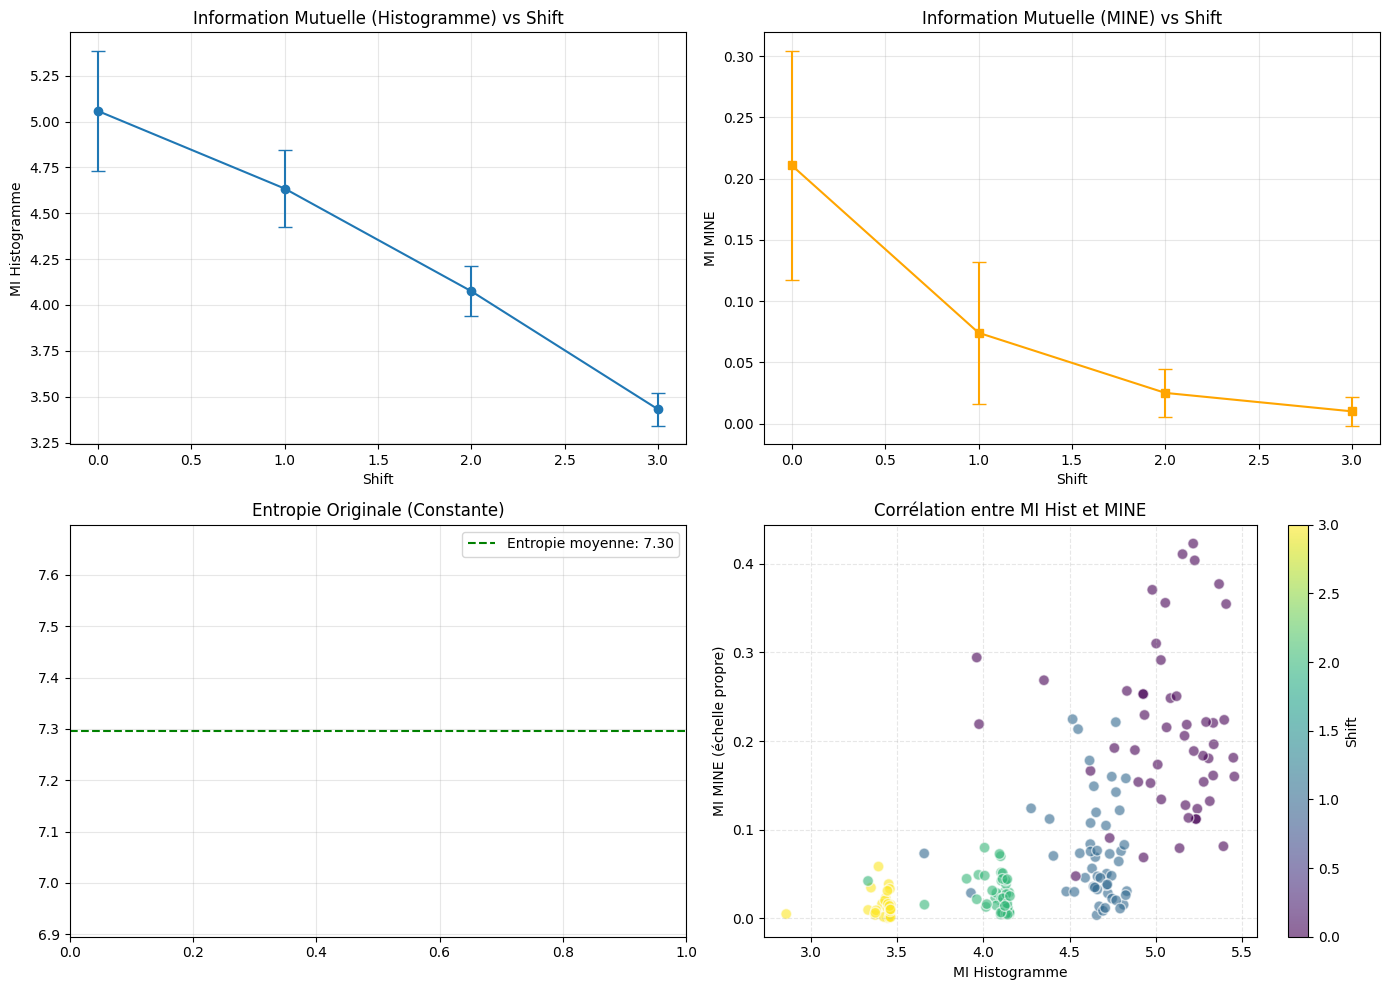

Graphiques sauvegardés dans 'results_analysis.png'


In [206]:
def plot_results(df_results):
    """
    Crée des visualisations des résultats.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. MI Histogram vs Shift
    grouped = df_results.groupby('shift')['mi_histogram'].agg(['mean', 'std'])
    axes[0, 0].errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], 
                        marker='o', capsize=5)
    axes[0, 0].set_xlabel('Shift')
    axes[0, 0].set_ylabel('MI Histogramme')
    axes[0, 0].set_title('Information Mutuelle (Histogramme) vs Shift')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. MI MINE vs Shift
    grouped_mine = df_results.groupby('shift')['mi_mine'].agg(['mean', 'std'])
    axes[0, 1].errorbar(grouped_mine.index, grouped_mine['mean'], 
                        yerr=grouped_mine['std'], marker='s', capsize=5, color='orange')
    axes[0, 1].set_xlabel('Shift')
    axes[0, 1].set_ylabel('MI MINE')
    axes[0, 1].set_title('Information Mutuelle (MINE) vs Shift')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Entropie moyenne
    entropy_mean = df_results.groupby('shift')['entropy_original'].mean().iloc[0]
    axes[1, 0].axhline(y=entropy_mean, color='green', linestyle='--', 
                       label=f'Entropie moyenne: {entropy_mean:.2f}')
    axes[1, 0].set_title('Entropie Originale (Constante)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Comparaison (Version améliorée)
    scatter = axes[1, 1].scatter(df_results['mi_histogram'], df_results['mi_mine'], 
                        alpha=0.6, c=df_results['shift'], cmap='viridis', edgecolors='w', s=60)

    axes[1, 1].set_xlabel('MI Histogramme')
    axes[1, 1].set_ylabel('MI MINE (échelle propre)')
    axes[1, 1].set_title('Corrélation entre MI Hist et MINE')

    # Ajouter une colorbar pour comprendre que la couleur = shift
    plt.colorbar(scatter, ax=axes[1, 1], label='Shift')

    # Supprimer la ligne y=x qui écrase tout
    # Si vous voulez voir la tendance, ajoutez une régression linéaire simple :
    # m, b = np.polyfit(df_results['mi_histogram'], df_results['mi_mine'], 1)
    # axes[1, 1].plot(df_results['mi_histogram'], m*df_results['mi_histogram'] + b, 'r--', label='Tendance')

    axes[1, 1].grid(True, alpha=0.3, linestyle='--')

    # Laisser matplotlib ajuster les échelles automatiquement ou forcer légèrement :
    # axes[1, 1].autoscale(enable=True, axis='both', tight=True)
        
    plt.tight_layout()
    plt.savefig('results_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Graphiques sauvegardés dans 'results_analysis.png'")

# Visualiser
plot_results(df_final)

In [207]:
def print_summary(df_results):
    """
    Affiche un résumé statistique des résultats.
    """
    print("\n" + "="*70)
    print("RÉSUMÉ DES RÉSULTATS PAR SHIFT")
    print("="*70)
    
    summary = df_results.groupby('shift').agg({
        'entropy_original': ['mean', 'std'],
        'mi_histogram': ['mean', 'std'],
        'mi_mine': ['mean', 'std']
    }).round(4)
    
    print(summary)
    
    print("\n" + "="*70)
    print("OBSERVATIONS")
    print("="*70)
    
    # Calcul de la perte d'information
    mi_hist_shift0 = df_results[df_results['shift'] == 0]['mi_histogram'].mean()
    mi_hist_shift8 = df_results[df_results['shift'] == 8]['mi_histogram'].mean()
    
    print(f"MI Histogramme à shift=0: {mi_hist_shift0:.4f}")
    print(f"MI Histogramme à shift=8: {mi_hist_shift8:.4f}")
    print(f"Perte d'information: {((mi_hist_shift0 - mi_hist_shift8) / mi_hist_shift0 * 100):.2f}%")

# Afficher le résumé
print_summary(df_final)


RÉSUMÉ DES RÉSULTATS PAR SHIFT
      entropy_original         mi_histogram         mi_mine        
                  mean     std         mean     std    mean     std
shift                                                              
0               7.2964  0.4711       5.0575  0.3265  0.2107  0.0933
1               7.2964  0.4711       4.6347  0.2110  0.0742  0.0577
2               7.2964  0.4711       4.0750  0.1350  0.0252  0.0194
3               7.2964  0.4711       3.4314  0.0881  0.0101  0.0115

OBSERVATIONS
MI Histogramme à shift=0: 5.0575
MI Histogramme à shift=8: nan
Perte d'information: nan%
